# Pricing interest rate swap and swaption from the zero-coupon rates' curve and 3/6-months Euribor forward rates' curves

### *Objective*: To price interest rate swaptions (and their underlying swaps), based on current market conditions.
From current market conditions, i.e. the zero-coupon rates' curve and 3/6-months Euribor forward rates' curves, we calculate:
- the spot swaps rates' curve with their par rate (i.e. the rates to get swap price = 0), and prices of theses swaps for a given swap rate, at different maturities.    
- the forward swaps rates' surface at different expiries and tenors.   
- a surface of swaptions' prices at different expiries and tenors for a given strike.
- the swaptions' prices for a given or at different option's maturities, and for a given underlying swap's tenor and strike.   

### *Main used notions*:     
- pricing of spot swap and forward swap
- identification of the implied volatilities through the use of the SABR model
- pricing of swaption using the Black model

### *Main used functions*:     
- *np.interp* : interpolate a continuous function **y** from discrete points **x** and **y**.  
- *scipy.interpolate.LinearNDInterpolator* : interpolate between 2 known points in multi-dimensional space.  
- *scipy.interpolate.NearestNDInterpolator* : interpolate from the nearest known point in multi-dimensional space. 

### *General structure of following script*: 
1. Functions of actualization through the zero-coupon rates' curve, and getting market's forward rates.   
2. From the market's forward rates and the discount factors, calculations regarding the swaps:    
-- curve of spot swaps' par rate, along different maturities.      
-- prices of spot swaps depending on multiple swap rates, at different maturities.  
-- surface of forward swaps' rate, along different expiries and tenors.    
3. Calculation of the corresponding swaption values:    
-- identification of the implied volatilities to calculate the values of the options, using the SABR model.   
-- cube of the swaptions' prices, along different option's maturities, swap's tenors and strikes.
4. Discussions about prices of swap and swaption depending on different parameters.  


In [2638]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
from dataclasses import dataclass

## Introduction: Get the zero-coupon rates' discount factors, and 3/6-months Euribor forward rates

In the project **Bootstrap_ZC_and_FWD_rates**, we calculated the zero-coupon rates and 3/6-months Euribor forward rates from market instruments (cash/deposit, futures, and swaps).   
Taking these rates as inputs, we interpolate them to get the discount factors and forward rates at the swap's fixing and payment dates. 

In [2639]:
@dataclass
class DiscountCurve:
    """
    Discount factors' curve from OIS rates
    """
    times: np.ndarray         # maturities in years
    dfs: np.ndarray           # corresponding discount factors

    def df(self, T: np.ndarray | float) -> np.ndarray | float:
        return np.interp(T, self.times, self.dfs)
    
@dataclass
class ForwardCurve:
    """
    Forward rates' curve from 3M or 6M Euribor rates
    """
    times: np.ndarray         # maturities in years
    forwards: np.ndarray      # corresponding forward rates

    def forward_rate(self, T: np.ndarray | float) -> np.ndarray | float:
        return np.interp(T, self.times, self.forwards)

## Part 1: Calculation of the spot swap and forward swap.

The part 1 is structured as following.
1. In a class related to the IRS, we calculate:      
-- the par rates at different maturities to get a par rates' curve of a spot swap.       
-- the present values of the swap at different maturities, and for a set of swap rates.   
-- the forward swaps' rate at different option's maturities and swap's tenors to get a forward rates' surface.

2. We plot for each calculation performed before:     
-- the par rates' curve and curves of the swaps' present values per chosen swap rate, each for different maturities.  
-- the forward swaps' rate's surface in 2 different graphs : in 3D and 2D

### Generate the par swap rates' and swap's present values' curves, and forward rates' surface.   

#### *Calculate the par swap rates' curve*.
$\boxed{PV_{\text{floating leg}}(L_1, L_2, …, L_n) = PV_{\text{fixed leg}}(S)}$ *where* $S$ the par swap rate

$ \Rightarrow N * \sum_{i=1}^{n} \delta_{\text{floating leg}} DF(T_{p_i}) L(t,T_{f_i},T_{p_i}) = N * \sum_{j=1}^{n}\delta_{\text{fixed leg}} DF(T_{p_j}) S(T_n) \Longrightarrow      \boxed{S(T_n) = \frac{\sum_{i=1}^{n} \delta_{\text{floating leg}} DF(T_{p_i}) L(t,T_{f_i},T_{p_i})}{\sum_{j=1}^{n}\delta_{\text{fixed leg}} DF(T_{p_j})}}$

We calculate $S(T_n)$ for a range of maturities, so that we can plot the curve of the par swap rates. 

#### *Calculate the swap's present values' curve*.
$\boxed{PV_{\text{swap}} = PV_{\text{floating leg}}(L_1, L_2, …, L_n) - PV_{\text{fixed leg}}(S)}$ for a swap payer (i.e. paying the fixed leg's rate and receiving the floating leg's rate).  

$ \Rightarrow \boxed{PV_{\text{swap}} = N * \left( \sum_{i=1}^{n} \delta_{\text{floating leg}} DF(T_{p_i}) L(t,T_{f_i},T_{p_i}) - \sum_{j=1}^{n}\delta_{\text{fixed leg}} DF(T_{p_j}) S(T_n) \right) }$

We define a set of swap rates $S(T_n)$ for a range of maturities, in order to visualize the swap's sensitivity to the fixed rate.   

#### *Calculate the forward rates' surface*.  
We use the exact same formula as for the spot swap's par rate.   
As a forward swap, the swap starts at a future moment compared to a spot swap starting right now.    
So we remove the cash-flows from both legs, generated before the forward swap starts.   
  
$\boxed{F(t, T_s, T_n) = \frac{\sum_{i=1}^{n} \delta_{\text{floating leg}} DF(T_{p_i}) L(t,T_{f_i},T_{p_i})}{\sum_{j=1}^{n}\delta_{\text{fixed leg}} DF(T_{p_j})} - \frac{\sum_{i=1}^{s} \delta_{\text{floating leg}} DF(T_{p_i}) L(t,T_{f_i},T_{p_i})}{\sum_{j=1}^{s}\delta_{\text{fixed leg}} DF(T_{p_j})}}$ 

We calculate $F(t, T_s, T_n)$ for a range of expiries $T_s$ and tenors $T_n$, so that we can plot the surface of the forward swap rates.


In [2640]:
@dataclass
class InterestRateSwapCurve:
    """
    Calculate at par spot IRS's curve, and at par forward IRS's surface 
    """
    float_tenor: str
    payer_receiver: str
    fixed_frequency: float
    Ks: np.ndarray
    min_maturity: float
    max_maturity: float
    step: float
    notional: float  

    def build_swap_curve(self, discount_curve, forward_curve):
        """
        Calculation of the actualized CFs for both fixed and floating legs
        """
        # Sum of the IRS' fixed leg's discount factors
        fixed_dt = self.fixed_frequency
        fixed_times = np.arange(fixed_dt, self.max_maturity + 1e-8, fixed_dt) # shape (N_fix,)
        df_fixed = discount_curve.df(fixed_times)                             # shape (N_fix,)
        level_CFs = fixed_dt * df_fixed                                       # shape (N_fix,)
        self.cumsum_level = np.cumsum(level_CFs)                              # shape (N_fix,) ==> cumulated discounted CFs

        # Sum of the IRS' floating leg's cashflows
        float_dt = 0.25 if self.float_tenor == "3M" else 0.5
        float_times = np.arange(float_dt, self.max_maturity + 1e-8, float_dt) # shape (N_flt,) 
        df_float = discount_curve.df(float_times)                             # shape (N_flt,)
        forward_rate_float = forward_curve.forward_rate(float_times)          # shape (N_flt,)
        float_CFs = float_dt * df_float * forward_rate_float                  # shape (N_flt,)
        self.cumsum_float = np.cumsum(float_CFs)                              # shape (N_flt,) ==> cumulated discounted CFs

        # Payment dates' indexes (for both legs)
        self.maturities = np.arange(self.min_maturity, self.max_maturity + 1e-8, self.step)  # shape (M,)
        self.fixed_times = fixed_times
        self.float_times = float_times
        idx_fixed = np.searchsorted(self.fixed_times, self.maturities, side="right") - 1
        idx_float = np.searchsorted(self.float_times, self.maturities, side="right") - 1

        # Sum of the discounted cashflows
        self.total_fixed_CFs = self.cumsum_level[idx_fixed]                  # shape (M,) ==> fixed leg's cumulated discounted CFs at fixed maturities
        self.total_float_CFs = self.cumsum_float[idx_float]                  # shape (M,) ==> floating leg's cumulated discounted CFs at fixed maturities

    
    def swap_par_rates(self):
        """
        Calculation of the swap's par rates (when swap's value = 0) along the maturities
        """
        self.swap_par_rates = self.total_float_CFs / self.total_fixed_CFs
    

    def swap_values(self):
        """
        Calculation of the swap's values along the maturities
        """    
        Ks = np.atleast_1d(self.Ks)
        if self.payer_receiver == "PAYER":
            self.npv = self.total_float_CFs[:, None] - self.total_fixed_CFs[:, None] * Ks[None, :]
                                                                              # shape (M, K.size)
        else:
            self.npv = self.total_fixed_CFs[:, None] * Ks[None, :] - self.total_float_CFs[:, None]  


    def forward_swap_surface(self):
        """
        Calculation of the forward swap's par rates (when swap's value = 0) along the expiries and tenors
        """   
        T0s = self.maturities[:, None]                                       # shape (M, 1) ==> expiries
        Tss = self.maturities[None, :]                                       # shape (1, M) ==> tenors
        T1s = T0s + Tss                                                      # shape (M, M) ==> maturities   
      
        valid = T1s <= self.max_maturity                                     # expiry + tenor > max maturity not considered

        # Fixing dates and payment dates' indexes (for both legs)
        idx_fi_T0 = np.searchsorted(self.fixed_times, T0s, side = "right") - 1
        idx_fi_T1 = np.searchsorted(self.fixed_times, T1s, side = "right") - 1
        idx_fl_T0 = np.searchsorted(self.float_times, T0s, side = "right") - 1
        idx_fl_T1 = np.searchsorted(self.float_times, T1s, side = "right") - 1  

        Lvl_T0 = self.cumsum_level[idx_fi_T0]     # shape (M, M) ==> fixed leg's cumulated discounted CFs at fixed maturities until expiry dates
        Lvl_T1 = self.cumsum_level[idx_fi_T1]     # shape (M, M) ==> fixed leg's cumulated discounted CFs at fixed maturities until payment dates
        F_T0 = self.cumsum_float[idx_fl_T0]       # shape (M, M) ==> floating leg's cumulated discounted CFs at fixed maturities until expiry dates
        F_T1 = self.cumsum_float[idx_fl_T1]       # shape (M, M) ==> floating leg's cumulated discounted CFs at fixed maturities until payment dates

        Lvl = Lvl_T1 - Lvl_T0
        F = F_T1 - F_T0

        Lvl[~valid] = np.nan
        F[~valid] = np.nan

        self.levels = Lvl                         # ==> used to price the swaptions
        self.forward_swap_rates = F / Lvl

### Plot the par swap rates' curve, and the swap's present values' curves

In [2641]:
def plot_swap_curve(IRS_curve):
    chapter("Chapter 1.\nSpot swap' prices.")
    
    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.plot(IRS_curve.maturities, IRS_curve.swap_par_rates * 100.0, lw=2, color="tab:blue", label="Par swap rate")
    ax1.set_xlabel("Maturity (years)")
    ax1.set_ylabel("Par swap rate (%)", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, which="both", ls="--", lw=0.5)

    ax2 = ax1.twinx()
    colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(IRS_curve.Ks)))
    for i, K in enumerate(IRS_curve.Ks):
        ax2.plot(IRS_curve.maturities, IRS_curve.npv[:,i], lw=1.8, ls="--", color = colors[i],
                 label=f"Swap value (K = {K*100:.2f}%)")
    ax2.axhline(0, color="grey", lw=0.8, ls="--")   
    ax2.set_ylabel("Swap value", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    fig.suptitle(f"{IRS_curve.float_tenor} forward, spot swap's par rates' curve, and value of {IRS_curve.payer_receiver} swap per swap rate")
    plt.tight_layout()
    plt.show()  

### Plot the forward swap rates' surface.  

We plot the surface in 3D and 2D to provide 2 views of the same forward rates.  
The 3D surface helps visualizing how the rates evolve along expiries and tenors.  
The 2D surface helps visualizing what the value of the rate is for each expiry and tenor 

In [2642]:
def plot_forward_swap_surface(IRS_curve):
    chapter("Chapter 2.\nForward swap rates.")

    # ------- 3D surface ------- #
    expiries, tenors = np.meshgrid(IRS_curve.maturities, IRS_curve.maturities) # Create a grid for the forward swaps' par rate
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(expiries, tenors, IRS_curve.forward_swap_rates * 100, cmap=cm.coolwarm, linewidth=0, antialiased=True)
    
    ax.view_init(elev=20, azim=10) # Set the viewing angle
    ax.set_xlabel('Expiry $T_0$ (years)')
    ax.set_ylabel('Tenor $T_s$ (years)')
    ax.set_zlabel('Par rate (%)')
    ax.set_title(f"{IRS_curve.float_tenor} forward, forward swap's par rate's 3D surface")
    plt.show()
    

    # ------- 2D surface ------- #
    fig, ax = plt.subplots(figsize=(8, 5))
    masked_surface = np.ma.masked_invalid(IRS_curve.forward_swap_rates)
    cmap=cm.coolwarm

    c = ax.pcolormesh(
        IRS_curve.maturities,
        IRS_curve.maturities,
        masked_surface * 100.0,
        shading="auto",
        cmap=cmap)
    
    ax.set_xlabel("Tenor $T_s$ (years)")
    ax.set_ylabel("Expiry $T_0$ (years)")
    ax.set_title(f"{IRS_curve.float_tenor} forward, forward swap's par rate's surface")
    fig.colorbar(c, ax=ax, label="Forward swap par rate (%)")

    # contour lines for readability (optional)
    ax.contour(
        IRS_curve.maturities, IRS_curve.maturities,
        masked_surface * 100.0,
        colors="black",
        linewidths=0.3,
        alpha=0.4
    )

    plt.tight_layout()
    plt.show()


## Part 2: Calculation of the swaption.   

The part 2 is structured as following.
1. In a class related to the SABR model, we calculate the implied volatilities for the option's maturities, swap's tenors and strikes used in pricing the swaptions.    
2. In a class related to the swaption, we calculate the prices of the swaptions at different option's maturities, swap's tenors and strikes.
3. From the calculation of the prices of swaptions, we extract the prices:       
-- we plot the prices as a curve with fixed tenor and strike, along different maturities.  
-- we print the price with with fixed maturity, tenor and strike.         

### Identify the implied volatilities used in calculation of the swaptions' price.  

The implied volatilities are identified thanks to the SABR model.   
The SABR model is based on parameters, which are calibrated based on market swaptions.  
This calibration is done in the separate project **SABR_calibration**.   

So we first identify by extrapolation the SABR parameters for the swaptions' processed option's maturities, swap's tenors and strikes.      
The extrapolation from the calibrated SABR parameters is performed within a dedicated class, using 2 functions of interpolation and extrapolation.    

#### *Interpolation and extrapolation of the SABR parameters*
The function of interpolation *scipy.interpolate.LinearNDInterpolator* does a linear interpolation (i.e. value **x** interpolated between 2 known points **f(x)**).   
The function does a linear interpolation in a multidimensional space : here, a 2-dimensions space with the option's maturity and swap's tenor, giving the volatility.   
With this function, interpolation has no oscillation and curvature.    
There is no need to have input data on a regular grid (contrary to more common functions such as *np.interp* or *scipy.interp1d* needing a regular grid).        

The function of extrapolation *scipy.interpolate.NearestNDInterpolator* does a linear extrapolation (i.e. value **x** extrapolated from the nearest single known point **f(x)**).  
Similarly to the previous function of interpolation, the extrapolation is done in a multidimensional space (here 2D space).   
With this function, interpolation has no oscillation. Nevertheless there is no continuation between points (unsmooth created curve).   
There is no need to have input data on a regular grid.

In [2643]:
class _InterAndExtrapolation:
    
    def __init__(self, points, values):
        self._interp = LinearNDInterpolator(points, values)
        self._extrap = NearestNDInterpolator(points, values)

    def __call__(self, X):
        out = self._interp(X)
        mask = np.isnan(out)
        if np.any(mask):
            out[mask] = self._extrap(X[mask])
        return out    

#### *Identify the SABR parameters*

The SABR parameters are :
- $\alpha$ : initial volatility of the forward 
- $\beta$ : elasticity ($\beta = 1$ for lognormal i.e. Black ; $\beta = 0$ for normal ; $0 < \beta < 1$ as intermediary)
- $\rho$ : forward/volatility correlation to control the asymetry of the smile of volatility
- $\nu$ : volatility of the volatility (vol-vol) to control the curvature of the smile of volatility

They depend on an option's maturity and a swap's tenor defining a swaption, and give a smile of volatility function of the strikes.      
For information, the market volatilities used in the calibration of the model are Black volatilities (i.e. volatilities calculated with the Black model).   
More information on the smile of volatility in the **SABR_calibrate** project.   

So we identify the SABR parameters from the maturities and tenors processed in this project, through interpolation/extrapolation. 

#### *Calculate the implied volatilities*
Then we calculate the implied volatilities for the processed maturities and tenors, depending on the underlying's forward rates and strikes.   

$\sigma_{SABR}(F, K) = \frac{\alpha}{(F K)^{\frac{1-\beta}{2}} \Big(1 + \frac{(1-\beta)^2}{24} (\ln \tfrac{F}{K})^2 + \frac{(1-\beta)^4}{1920} (\ln \tfrac{F}{K})^4 \Big)} \cdot \frac{z}{x(z)} \cdot \Bigg[ 1 + \Big( \frac{(1-\beta)^2}{24} \frac{\alpha^2}{(F K)^{1-\beta}} \frac{\rho \beta \nu \alpha}{4 (F K)^{\frac{1-\beta}{2}}} \frac{2 - 3 \rho^2}{24} \nu^2 \Big) T \Bigg] $

*avec* :   
$z = \frac{\nu}{\alpha} (F K)^{\frac{1-\beta}{2}} \ln \frac{F}{K}$  

$x(z) = \ln \left( \frac{ \sqrt{1 - 2 \rho z + z^2} + z - \rho }{1 - \rho} \right)$ 

*Particular case $ \Rightarrow $ when K = F (ATM)* :

$\sigma_{SABR}(F, K) = \frac{\alpha}{(F K)^{\frac{1-\beta}{2}} \Big(1 + \frac{(1-\beta)^2}{24} (\ln \tfrac{F}{K})^2 + \frac{(1-\beta)^4}{1920} (\ln \tfrac{F}{K})^4 \Big)} \cdot \Bigg[ 1 + \Big( \frac{(1-\beta)^2}{24} \frac{\alpha^2}{(F K)^{1-\beta}} \frac{\rho \beta \nu \alpha}{4 (F K)^{\frac{1-\beta}{2}}} \frac{2 - 3 \rho^2}{24} \nu^2 \Big) T \Bigg] $


In [2644]:
@dataclass
class SABRSurface:
    """
    Calculate the implied volatility's surface.
    """
    SABR_Ts_opt: np.ndarray
    SABR_Ts_swap: np.ndarray
    SABR_Fs: np.ndarray
    SABR_alphas: np.ndarray
    SABR_rhos: np.ndarray
    SABR_nus: np.ndarray

    def __post_init__(self):
        SABR_Ts_opt_swap = np.column_stack([self.SABR_Ts_opt, self.SABR_Ts_swap])   # combination, based for following interpolation 

        # Interpolation of the SABR parameters based on the option's maturity and swap's tenor
        self.alphas_interp = _InterAndExtrapolation(SABR_Ts_opt_swap, self.SABR_alphas)
        self.rhos_interp = _InterAndExtrapolation(SABR_Ts_opt_swap, self.SABR_rhos)
        self.nus_interp = _InterAndExtrapolation(SABR_Ts_opt_swap, self.SABR_nus)


    @staticmethod
    def sabr_implied_vol(F, K, T, alpha, beta, rho, nu, shift=0):
        """
        Calculate the SABR volatility for given parameters.
        """
        K = np.array(K, dtype=float)
        F = F + shift
        K = K + shift
        
        eps = 1e-07
        logfk = np.log(F / K)
        fkbeta = (F*K)**(1 - beta)
        a = (1 - beta)**2 * alpha**2 / (24 * fkbeta)
        b = 0.25 * rho * beta * nu * alpha / fkbeta**0.5
        c = (2 - 3*rho**2) * nu**2 / 24.
        d = fkbeta**0.5
        v = (1 - beta)**2 * logfk**2 / 24
        w = (1 - beta)**4 * logfk**4 / 1920
        z = nu * fkbeta**0.5 * logfk / alpha
        tmp = alpha * (1 + (a + b + c) * T)
        num = np.where(abs(z) > eps, z * tmp, tmp)
        den = np.where(abs(z) > eps, (d * (1 + v + w) * SABRSurface._x(rho, z)), d * (1 + v + w))
        return num / den

    @staticmethod
    def _x(rho, z):
        a = (1 - 2*rho*z + z**2)**0.5 + z - rho
        b = 1 - rho
        return np.log(a / b)     


    def get_vol_surface(self, Ts_opt, Ts_swap, Fs, Ks):
        Ts_opt_grid, Ts_swap_grid = np.meshgrid(Ts_opt, Ts_swap, indexing='ij')
        Ts_opt_swap = np.column_stack([Ts_opt_grid.ravel(), Ts_swap_grid.ravel()])  # (M*M)

        alphas = self.alphas_interp(Ts_opt_swap)                  # (M*M)
        betas = np.full_like(alphas, 0.5)                         # (M*M)
        rhos = self.rhos_interp(Ts_opt_swap)                      # (M*M)
        nus = self.nus_interp(Ts_opt_swap)                        # (M*M)

        Fs = np.asarray(Fs.ravel())[:, None]                      # (M*M, 1)
        Ks = np.asarray(Ks)[None, :]                              # (1, N)
        Ts = np.repeat(np.asarray(Ts_opt), Ts_swap.size)[:, None] # (M*M, 1)
        alphas = np.asarray(alphas)[:, None]                      # (M*M, 1)
        betas = np.asarray(betas)[:, None]                        # (M*M, 1)
        rhos = np.asarray(rhos)[:, None]                          # (M*M, 1)
        nus = np.asarray(nus)[:, None]                            # (M*M, 1)  
        
        vols = SABRSurface.sabr_implied_vol(Fs, Ks, Ts, alphas, betas, rhos, nus)
        self.vols = vols.reshape(Ts_opt.size, Ts_swap.size, vols.shape[1])

### Plot the implied volatilities' 2D surface.  
We plot the implied volatilities' 2D surface to get an overview of the volatility for a given strike along the option's maturities and swap's tenors.    

In [2645]:
def plot_vol_surface(IRS_curve, SABR_surface, K, k):  
    chapter("Chapter 3.\nImplied volatilities.")

     # ------- 2D surface ------- #
    fig, ax = plt.subplots(figsize=(8, 5))
    vol_surface_k = SABR_surface.vols[:, :, k]
    masked_surface = np.ma.masked_invalid(vol_surface_k)
    cmap=cm.coolwarm

    c = ax.pcolormesh(
        IRS_curve.maturities,
        IRS_curve.maturities,
        masked_surface,
        shading="auto",
        cmap=cmap)
    
    ax.set_xlabel("Tenor $T_s$ (years)")
    ax.set_ylabel("Expiry $T_0$ (years)")
    ax.set_title(f"SABR implied volatility's surface for K = {K*100}%")
    fig.colorbar(c, ax=ax, label="SABR implied volatility")

    # contour lines for readability (optional)
    ax.contour(
        IRS_curve.maturities, IRS_curve.maturities,
        masked_surface * 100.0,
        colors="black",
        linewidths=0.3,
        alpha=0.4
    )

    plt.tight_layout()
    plt.show()

### Generate the swaptions' prices' cube.  
We calculate the prices of the swaptions depending on:
- the option's maturities
- the swap's tenors
- the strikes

$\boxed{PV_{\text{payer swaption}} = N \cdot \sum_{j=1}^{n}\delta_{\text{fixed leg}} DF(T_{p_j}) \cdot \max \Big (F(t, T_s, T_n) - K, 0 \Big)} \Leftarrow \Rightarrow \boxed{PV_{\text{receiver swaption}} = N \cdot \sum_{j=1}^{n}\delta_{\text{fixed leg}} DF(T_{p_j}) \cdot \max \Big (K - F(t, T_s, T_n), 0 \Big)}$     

*where*:   
$F(t, T_s, T_n)$ the underlying's forward rate

The investor owns an option on a swap.
1. **Value of the option**    
Working with Black volatilities on forward rate, we use the Black formula to evaluate the value of the option at maturity.   
$\boxed{C_t = \max \Big(F(t, T_s, T_n) - K, 0 \Big) = e^{-r(T_n - t)} \Big(F_t N(d_1) - K N(d_2)\Big)} \Leftarrow \Rightarrow \boxed{P_t = \max \Big(K - F(t, T_s, T_n), 0 \Big) = e^{-r(T_n - t)} \Big( K N(-d_2) - F_t N(-d_1) \Big)}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*where*:     
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\boxed{d_1 = \frac{\ln(F/K) + \frac{1}{2}\sigma^2 T}{\sigma \sqrt{T}}} \quad \Leftarrow \Rightarrow \quad \boxed{d_2 = d_1 - \sigma \sqrt{T}}$    

2. **Value of the swap**        
When activating the option and owner of a payer swap, we get the floating leg's cash-flows whether the underlying's forward rate is higher than the strike     
$ \Rightarrow  PV_{\text{payer swap}} = N \cdot \Big( \sum_{i=1}^{n} L(t,T_{f_i},T_{p_i}) \cdot \delta_{\text{floating leg}} DF(T_{p_i}) - K \cdot \sum_{j=1}^{n}\delta_{\text{fixed leg}} DF(T_{p_j}) \Big)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;When activating the option and owner of a receiver swap, we get the fixed leg's cash-flows whether the underlying's forward rate is lower than the strike     
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$ \Rightarrow  PV_{\text{receiver swap}} = N \cdot \Big( K \cdot \sum_{j=1}^{n}\delta_{\text{fixed leg}} DF(T_{p_j}) -  \sum_{i=1}^{n} L(t,T_{f_i},T_{p_i}) \cdot \delta_{\text{floating leg}} DF(T_{p_i}) \Big)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*where*:    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\boxed{\sum_{j=1}^{n}\delta_{\text{fixed leg}} DF(T_{p_j}) = \frac{\sum_{i=1}^{n} \delta_{\text{floating leg}} DF(T_{p_i}) L(t,T_{f_i},T_{p_i})}{S(T_n)}}$

3. **Replication of the underlying swap through the swaptions**   
To replicate a swaption such as a payer swaption, the investor:
- buys a payer swaption i.e. buys a call on the payer swap i.e. buys the right to pay the fixed leg  
- sells a receiver swaption i.e. sells a put on the receiver swap i.e. sells the right to receive the fixed leg    
$\Rightarrow \boxed{PV_{\text{payer swap}} = PV_{\text{payer swaption}} - PV_{\text{receiver swaption}}}$


In [2646]:
@dataclass
class SwaptionPricerCube:
    """
    Price a swaption cube. 
    """
    T0s: np.ndarray        # shape (M,)
    Tss: np.ndarray        # shape (M,)  
    Ks: np.ndarray         # shape (N,)
    Fs: np.ndarray         # shape (M, M)
    Lvls: np.ndarray         # shape (M, M)
    vols: np.ndarray       # shape (M, M, N)
    payer_receiver: str
    notional: float 

    def price_black(self):
        Fs = self.Fs[:, :, None]          # shape (M, M, 1)
        Lvls = self.Lvls[:, :, None]      # shape (M, M, 1)
        Ks = self.Ks[None, None, :]       # shape (1, 1, N)
        sigmas = self.vols                # shape (M, M, N)
        Ts = self.T0s[:, None, None]      # shape (M, 1, 1)

        d1 = (np.log(Fs/Ks) + (0.5 * sigmas**2 * Ts)) / (sigmas * np.sqrt(Ts))
        d2 = d1 - (sigmas * np.sqrt(Ts))

        prices_payer = Lvls * (Fs * norm.cdf(d1) - Ks * norm.cdf(d2))
        prices_receiver = Lvls * (Ks * norm.cdf(-d2) -  Fs * norm.cdf(-d1))

        if self.payer_receiver == "PAYER":
            prices = prices_payer
            prices_equiv = prices_receiver * -1
        else:
            prices = prices_receiver
            prices_equiv = prices_payer * -1

        self.prices = self.notional * prices  
        self.prices_equiv = self.notional * prices_equiv 


### Plot the swaptions' price's 2D surface.  
We plot the prices of the swaptions on a 2D surface to get an overview of the swaptions' prices for a given strike along the option's maturities and swap's tenors.  

In [2647]:
def plot_swaption_price_surface(IRS_curve, swaption_pricer, K, k): 
    chapter("Chapter 4.\nSwaption's prices.") 
     # ------- 2D surface ------- #
    fig, ax = plt.subplots(figsize=(8, 5))
    price_surface_k = swaption_pricer.prices[:, :, k]
    masked_surface = np.ma.masked_invalid(price_surface_k)
    cmap=cm.coolwarm

    c = ax.pcolormesh(
        IRS_curve.maturities,
        IRS_curve.maturities,
        masked_surface,
        shading="auto",
        cmap=cmap)
    
    ax.set_xlabel("Tenor $T_s$ (years)")
    ax.set_ylabel("Expiry $T_0$ (years)")
    ax.set_title(f"{IRS_curve.float_tenor} forward, {IRS_curve.payer_receiver} swaption price's surface for K = {K*100}%")
    fig.colorbar(c, ax=ax, label="Swaption price")

    # contour lines for readability (optional)
    ax.contour(
        IRS_curve.maturities, IRS_curve.maturities,
        masked_surface * 100.0,
        colors="black",
        linewidths=0.3,
        alpha=0.4
    )

    plt.tight_layout()
    plt.show()

## Part 3. Calculation and discussion of the swaps and swaptions' prices.   
We extract the prices of the swaps and swaptions from the forward rates' and swaptions' prices' surfaces previously calculated:
- for a given swap's tenor and strike along different option's maturities. 
- for a given option's maturity, swap's tenor and strike.  

In [2648]:
def swaption_prices(IRS_curve, swaption_pricer_cube, T0_target, Ts_target, Ks, K_target):
    i = np.argmin(np.abs(IRS_curve.maturities - T0_target))
    j = np.argmin(np.abs(IRS_curve.maturities - Ts_target))
    k = np.argmin(np.abs(Ks - K_target))

    # -- Identification of forward rate and ----------------------------------------------------------#
    # -- calculation of the curve of the prices of the swaps depending on the option's maturities --- #
    F_curve = IRS_curve.forward_swap_rates[:, j]
    Lvl_curve = IRS_curve.levels[:, j]
    
    if IRS_curve.payer_receiver == "PAYER":
        swap_prices_curve = IRS_curve.notional * Lvl_curve * (F_curve - Ks[k])
    else:
        swap_prices_curve = IRS_curve.notional * Lvl_curve * (Ks[k] - F_curve)    

    F_rate = IRS_curve.forward_swap_rates[i, j]
    Lvl_price = IRS_curve.levels[i, j]

    if IRS_curve.payer_receiver == "PAYER":
        swap_price = IRS_curve.notional * Lvl_price * (F_rate - Ks[k])
    else:
        swap_price = IRS_curve.notional * Lvl_price * (Ks[k] - F_rate)        

    # ---------------------------- Identification of the price of the swap ------------------------- #
    swaption_prices_curve = swaption_pricer_cube.prices[:, j, k]
    swaption_price = swaption_pricer_cube.prices[i, j, k]
    swaption_price_equiv = swaption_pricer_cube.prices_equiv[i, j, k]

    return F_curve, F_rate, swap_prices_curve, swap_price, swaption_prices_curve, swaption_price, swaption_price_equiv, i, j, k

### Plot the swaps' and swaptions' prices' curve, along different maturities     
We plot the curve of the prices of the swaps and swaptions, and the curve of the forward rates, for a given swap's tenor and strike along the option's maturities.


In [2649]:
def plot_swaption_swap_price_curve(IRS_curve, Ks, j, k, F_curve, swap_prices_curve, swaption_prices_curve):
    chapter("Chapter 5.\nSwap's and Swaption's prices.") 
    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.plot(IRS_curve.maturities, F_curve * 100.0, lw=2, color="tab:blue", label="Forward swap rate")
    ax1.set_xlabel("Option's maturity (years)")
    ax1.set_ylabel("Forward swap rate (%)", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, which="both", ls="--", lw=0.5)

    ax2 = ax1.twinx()
    ax2.plot(IRS_curve.maturities, swap_prices_curve, color="tab:red", ls="--", label=f"Swap Price")
    ax2.plot(IRS_curve.maturities, swaption_prices_curve, color="tab:orange", ls="--", label=f"Swaption Price")

    ax2.axhline(0, color="grey", lw=0.8, ls="--")   
    ax2.set_ylabel("Swap/Swaption value", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    fig.suptitle(f"{IRS_curve.float_tenor} forward, {IRS_curve.payer_receiver} swap/swaption price with tenor = {IRS_curve.maturities[j]:.0f} years and K = {Ks[k]*100:.2f}%")
    plt.tight_layout()
    plt.show()  
    

### Print the swap's and swaption's prices     
We print the prices of a swap and swaption for a given option's maturity, swap's tenor and strike.

In [2650]:
def print_swaption_swap_price(IRS_curve, Ks, i, j, k, F_rate, swap_price, swaption_price, swaption_price_equiv):
    print("." * 100)
    print(f"Option's maturity = {IRS_curve.maturities[i]:.0f} years")
    print(f"Swap's tenor = {IRS_curve.maturities[j]:.0f} years")
    print(f"Strike = {Ks[k] * 100:.2f}%")
    print(f"Forward rate = {F_rate * 100:.2f}%")
    print(f"Value of the {IRS_curve.float_tenor} forward, {IRS_curve.payer_receiver} swap = {swap_price}")
    print(f"Value of the {IRS_curve.float_tenor} forward, {IRS_curve.payer_receiver} swaption = {swaption_price}")

    swap_price_2 = swaption_price + swaption_price_equiv
    if IRS_curve.payer_receiver == "PAYER":
        IRS_curve.payer_receiver_equiv = "RECEIVER"
    else:
        IRS_curve.payer_receiver_equiv = "PAYER"   
    print("Validation of the value of the swaption through comparison with the swap's value:")    
    print(f"- {IRS_curve.payer_receiver} swap = {swap_price_2} = {IRS_curve.payer_receiver} swap - {IRS_curve.payer_receiver_equiv} swap ({swaption_price_equiv})")

    print("." * 100)


In [2654]:
def chapter(text):
    
    lines = text.split("\n")
    max_len = max(len(line) for line in lines)
    width = max_len + 4

    print("." * width)
    for line in lines:
        print(f". {line.ljust(max_len)} .")
    print("." * width)

## Execution of the project.  

1. We provide the zero-coupon rates and 3/6-month forward rates calculated from market instruments in the **bootstrap_ZC_and_FWD_rates** project.  
2. We define the parameters of the swaps and swaptions to price such as:  
-- the underlying swap's floating leg's forward rate    
-- the type "payer" or "receiver"  
-- the min and max maturities within to calculate the swaps and swaptions (maturity = expiry (i.e. option's maturity) + swap's tenor)     
-- the strikes
3. We provide the SABR parameters calibrated from market swaptions in the **SABR_calibration** project.  
4. We calculate for the swaps:     
-- the spot swap's par rate along different maturities.     
-- the spot swap's prices along different maturities for different strikes.  
-- the forward rates along different expiries and tenors.  
4. We calculate the implied volatilities with the SABR model.   
5. We calculate the prices of swaptions for different option's maturities, swap's tenors and strikes, using the Black model. 

In [2652]:
def main():

    # ------------ Input data for swap pricing ---------------------------------------------------------------- #
    ZC_rates = [(0.002739, 0.0400),(0.005479, 0.0399),(0.01923, 0.0399),(0.08333333333333333, 0.0397),
                (0.25, 0.0391),(0.5, 0.0384),(1.0, 0.0368),(2.0, 0.0343),(5.0, 0.0303),(7.0, 0.0283),
                (10.0, 0.0269),(15.0, 0.0255),(20.0, 0.0242),(30.0, 0.0237),(40.0, 0.0227),(50.0, 0.0224)]
    
    fwd_3m_rates = [(0.25, 0.0388),(0.5, 0.0382),(0.75, 0.0376),(1.0, 0.0370),(2.0, 0.0301),
                    (3.0, 0.0280),(4.0, 0.0255),(5.0, 0.0248),(6.0, 0.0240),(7.0, 0.0238),
                    (8.0, 0.0231),(9.0, 0.0223),(10.0, 0.0222),(11.0, 0.0219),(12.0, 0.0217),
                    (13.0, 0.0214),(14.0, 0.0211),(15.0, 0.0211),(20.0, 0.0198),(25.0, 0.0200),
                    (30.0, 0.0201),(40.0, 0.0193),(50.0, 0.0210)]
    
    fwd_6m_rates = [(0.5, 0.0396),(1.0, 0.0381),(2.0, 0.0309),(3.0, 0.0286),(4.0, 0.0263),
                    (5.0, 0.0255),(6.0, 0.0249),(7.0, 0.0245),(8.0, 0.0236),(9.0, 0.0227),
                    (10.0, 0.0225),(11.0, 0.0223),(12.0, 0.0220),(13.0, 0.0217),(14.0, 0.0215),
                    (15.0, 0.0214),(20.0, 0.0201),(25.0, 0.0202),(30.0, 0.0205),(40.0, 0.0197),
                    (50.0, 0.0216)]
    
    float_tenor = "3M"                                                                # "3M" or "6M" to enter
    assert float_tenor in ("3M", "6M")
    payer_receiver = "PAYER"                                                          # "PAYER" or "RECEIVER" to enter
    assert payer_receiver in ("PAYER", "RECEIVER")
    fixed_frequency = 1.0                                                             # fixed leg's frequency of payment
    min_maturity = 1.0                                                                # min_maturity to enter
    max_maturity = 30.0                                                               # max_maturity to enter
    step = 1.0                                                                        # step between each calculated swap's maturity to enter
       
    # Swap rates Ks to calculate ranges of values of swaps
    K = 0.0225                                                                        # Swap rate K to enter
    Ks = np.array([K - 0.005, K, K + 0.005])
    k = 1                                                                             # Index of the swap rate K in the list (distinguishing the original strike)

    # Swap / swaption conditions to calculate their values
    T0_target = 5.0                                                                   # Option's maturity T0 to enter
    Ts_target = 10.0                                                                  # Swap's tenor Ts to enter
    K_target = 0.0225                                                                 # Strike K to enter

    # Initialize the Interest Rate Swap's curve's characteristics
    IRS_curve = InterestRateSwapCurve(float_tenor, payer_receiver, fixed_frequency, Ks, min_maturity, max_maturity, step, notional=1)  


    # ------------ Additional input data for swaption pricing ---------------------------------------------- #
    # SABR parameters for a set of option's maturities, swap's tenors and forward values
    SABR_Ts_opt = np.array([
        0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0,
        2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0,
        5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 10.0, 10.0, 10.0, 10.0, 10.0,
        10.0, 10.0, 10.0, 10.0, 10.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 20.0, 20.0, 20.0, 20.0, 20.0,
        20.0, 20.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0
        ])
        
    SABR_Ts_swap = np.array([
        1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30,
        1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30,
        1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 1, 2, 3, 4, 5,7, 10, 15, 20, 30,
        1, 2, 3, 4, 5, 7, 10, 15, 20, 30
        ])

    SABR_Fs = np.array([
        0.037258, 0.036558, 0.035858, 0.035158, 0.034458, 0.033058, 0.030958, 0.027458, 0.023958, 0.016958, 0.037175, 0.036475, 0.035775, 0.035075, 0.034375, 
        0.032975, 0.030875, 0.027375, 0.023875, 0.016875, 0.03705, 0.03635, 0.03565, 0.03495, 0.03425, 0.03285, 0.03075, 0.02725, 0.02375, 0.01675,
        0.0368, 0.0361, 0.0354, 0.0347, 0.034, 0.0326, 0.0305, 0.027, 0.0235, 0.0165, 0.0363, 0.0356, 0.0349, 0.0342, 0.0335, 0.0321, 0.03, 0.0265, 0.023, 0.016,
        0.0358, 0.0351, 0.0344, 0.0337, 0.033, 0.0316, 0.0295, 0.026, 0.0225, 0.0155, 0.0353, 0.0346, 0.0339, 0.0332, 0.0325, 0.0311, 0.029, 0.0255, 0.022, 0.015,
        0.0348, 0.0341, 0.0334, 0.0327, 0.032, 0.0306, 0.0285, 0.025, 0.0215, 0.0145, 0.0338, 0.0331, 0.0324, 0.0317, 0.031, 0.0296, 0.0275, 0.024, 0.0205, 0.0135,
        0.0323, 0.0316, 0.0309, 0.0302, 0.0295, 0.0281, 0.026, 0.0225, 0.019, 0.012, 0.0298, 0.0291, 0.0284, 0.0277, 0.027, 0.0256, 0.0235, 0.02, 0.0165, 0.01,
        0.0273, 0.0266, 0.0259, 0.0252, 0.0245, 0.0231, 0.021, 0.0175, 0.014, 0.01, 0.0223, 0.0216, 0.0209, 0.0202, 0.0195, 0.0181, 0.016, 0.0125, 0.01, 0.01
        ])

    SABR_alphas = np.array([
        0.07671160893697229, 0.07519952972846745, 0.07442342956536456, 0.0734316213725642, 0.07257282969551454, 
        0.07084797449591919, 0.06757682785282278, 0.06447293805466654, 0.059699703720086844, 0.05092792342477817,
        0.07617750369000437, 0.07475228104126334, 0.07389595316836388, 0.07344771597598526, 0.07218494806464228,
        0.07050510873508153, 0.06826948981631703, 0.06399080802604629, 0.059089062021664536, 0.049613603157930806,
        0.07584428231609137, 0.07378381648685708, 0.07288201893643356, 0.07255141301605057, 0.07172311276089967,
        0.06959796537749009, 0.06739835193250428, 0.06328300830207749, 0.05884843191085432, 0.0501854793774112,
        0.07430243770259755, 0.0736903038086154, 0.07188175977289381, 0.07186120648879667, 0.07021975512509179,
        0.0681017506555802, 0.06683901216701098, 0.06223787675313881, 0.05826802303617085, 0.049140550491390295,
        0.07331336158592718, 0.07126261304419697, 0.07024633106806205, 0.070646524143944, 0.06866661686179164,
        0.06744766413887011, 0.06444701625982903, 0.059810138185175894, 0.0553933432736512, 0.04580889458019161,
        0.06988643997761167, 0.0693530419467693, 0.07028758782577633, 0.06744444410877884, 0.06652014402961355,
        0.06555826823237801, 0.06396713049105751, 0.05861559522473462, 0.05455365703454918, 0.04628323991270519,
        0.06785268011559907, 0.06776103120481444, 0.06845449413468878, 0.06645444740163549, 0.06616741566372415,
        0.06511213604653979, 0.06130366531220412, 0.05816191738327602, 0.0508294037041553, 0.04280366500049685,
        0.0687426371872433, 0.06673685527616982, 0.06574676586384691, 0.06472961390111387, 0.06458579091892097,
        0.06167959323569095, 0.060876418488612055, 0.05840199245483379, 0.05079772544022091, 0.043260839219547514,
        0.06418294841054134, 0.06620782642027113, 0.06624114036062018, 0.0649305181676933, 0.06254425120816529,
        0.06116686268425111, 0.05832433366393622, 0.054508765724319376, 0.04840220936021021, 0.041718694914094405,
        0.06298562488605762, 0.06042873268794632, 0.059369218497585134, 0.05838450022703712, 0.06040759394415601,
        0.0606818802837466, 0.057085469611263095, 0.05215971538878339, 0.044360035303157866, 0.03760478539409997,
        0.0626688793552195, 0.05852342407944639, 0.05699387187817029, 0.05752099100121601, 0.05166923917338899,
        0.05479440067697751, 0.05019693095655828, 0.045175089693641625, 0.04171611922606088, 0.08199025673733736,
        0.05583333431403109, 0.054464406336013405, 0.05178345060861989, 0.05470840277476462, 0.05353818091833748,
        0.051306672158392984, 0.04929041260222138, 0.03802625449961206, 0.04080950654061359, 0.0656024691736021,
        0.04973637961332425, 0.048195097722759275, 0.04646817209165567, 0.048781001536162154, 0.042789556652473186,
        0.04088674732199715, 0.03792415203948278, 0.033943258818453455, 0.03020789943245358, 0.05023637946184629
        ])
  
    SABR_rhos = np.array([
        0.001967288103400551, -2.09511716582774e-06, 0.06407168638751708, 1.754036809480484e-07, 6.133413750967074e-06,
        0.0035213641206659567, 0.03485924091928779, 0.11584678347392698, -3.1453971817870245e-07, 0.4323228747956202,
        -1.5068693599093965e-05, 0.006283787340676138, 0.0003825312999242215, 9.787421324434097e-07, 1.5758344684609247e-13,
        -0.0001327577858423724, 8.504240033523321e-06, -1.6852758399997643e-06, 0.009852426719179675, 0.16337599368963002,
        0.0014854727097916255, -1.6843645927922668e-06, 0.0498189494114559, -5.4648917616996865e-06, 0.035802300195837314,
        -0.0010928443814781708, 0.05839409636367852, 7.037218774585179e-09, 0.12093046438062877, 0.22276890701403307,
        -0.0006833530698986138, 8.282146301145298e-08, -0.0005433980180378974, 3.6389060627876926e-14, 0.0005101380460444782,
        0.04536022729194356, 0.016678004278211377, 5.406568749238193e-08, 0.06722327070439015, 0.23222164985262692,
        -0.0013103469331986687, 3.712117038021572e-12, -4.081232848533218e-06, -1.9034356686494266e-05, 3.1075334042046656e-11,
        1.4054791551172837e-11, -4.824693809097954e-06, 0.001209202792524028, 0.04553076376719907, 0.1094139179805202,
        6.476297451102602e-07, -4.853866715746992e-07, -4.546270977694904e-06, -3.0800044156642274e-05, 1.9487587101217923e-12,
        -2.726157109385693e-05, 0.00015248423043225383, 1.2808409908992757e-10, 0.10847608780761087, 0.3234213766830759,
        -6.000264360574747e-06, -2.7058952144674288e-06, 1.8417388591482216e-07, -4.708871542456108e-05, 7.449363266102904e-05,
        0.0118743799983617, 1.7257239617877648e-06, 0.02323582861996182, 0.07472822881628262, 0.2146002453505353,
        4.088802094110319e-08, -1.774858654385034e-07, 9.101778064925805e-06, 2.8810517243228577e-12, 0.00628697687675264,
        1.1809647488029322e-07, 3.873829997494187e-05, -1.0142953704058434e-07, 0.13721925163502807, 0.32292059788233346,
        -1.1494884622910332e-07, 0.038900565052030205, -0.001199308988584184, -7.966345523970075e-10, -1.4044510801370457e-08,
        0.0008633502896182619, -5.243686399208869e-09, 0.028735708052049794, 0.12414890623309931, 0.863521586716459,
        -2.223252221344033e-10, 0.039281838827330905, -9.59506880590593e-06, 0.10605713896763565, -1.277290987693088e-16,
        0.0004088349842764575, 0.15735022139545465, -3.344170967607681e-12, 0.13343123629186923, 0.5801808453106592,
        0.044193275134264534, -2.4706034759529463e-07, -3.093122878006226e-06, 0.15000647211686857, 0.06365719472969154,
        0.12634991193559758, 0.10031951786990248, 0.21880487439379126, 0.17949406446216246, -0.9379946629316565,
        0.0005634629134347706, -1.4202537058451064e-07, 6.938171925267371e-05, 0.3036197945850445, 0.03933041710117796,
        0.024978555821523918, 0.15820778364773264, 0.22904411956522608, 0.8670005658840177, -0.8289742667349974,
        0.6047762407369213, 0.017275889676941866, 0.10727715809580876, 0.05676127217589104, 0.21486907351672452,
        0.1925266522103332, 0.32046133422196105, 0.5756127490782204, 0.9958746050988766, -0.6957186302972956
        ])

    SABR_nus = np.array([
        0.1500635709693305, 0.41312376860742434, 0.3352004145377033, 0.36392562309623777, 0.27359747987066146,
        0.3117450770430459, 0.4562505423869568, 0.08478566018936094, 0.2586533553921684, 0.03924607684571514,
        0.22053760842296305, 0.3275850834793369, 0.31949420656594435, 0.07824540855127249, 0.28522408170975155,
        0.2692177276912101, 0.07920425153393475, 0.1968057577367667, 0.28430453402422895, 0.2845676957808904,
        0.16654545588283398, 0.4299238667102592, 0.38222327168965337, 0.2138113360957015, 0.2421106126354864,
        0.32177267285412914, 0.25344336963231423, 0.19723625531291122, 0.16452256263003548, 0.19403212511121776,
        0.28281023027687396, 0.17654526215368108, 0.33226423930897137, 0.09292618818337287, 0.30593454882149784,
        0.3544207373322722, 0.10378903007877154, 0.23656001926677409, 0.15669721087982824, 0.2040467287863482,
        0.12939180169400782, 0.28128606274219464, 0.29826771322513, 0.07482410823991277, 0.28205991163491206,
        0.21363453620264142, 0.26979229022657525, 0.3270931658911111, 0.31363590697364946, 0.3191309303660896,
        0.3592897190753369, 0.3099360256126588, 0.08993883793839437, 0.3200436196096979, 0.32077793968222645,
        0.27099295074067614, 0.1586583124102351, 0.27998724257260665, 0.28311982206471686, 0.20743364457241537,
        0.3765069154731254, 0.3222236332598474, 0.1805125664828199, 0.27789720443720817, 0.2398151710912443,
        0.1698490215100097, 0.2954357446411695, 0.21111123474176777, 0.40695055159721283, 0.2976524060407575,
        0.24046698018036536, 0.2979467588026555, 0.3029916034656871, 0.30515530119886836, 0.26871695887536157,
        0.3367124537533475, 0.2378567891719527, 0.054833078711957375, 0.31143158708102536, 0.20549342160067705,
        0.3367357255476859, 0.19231113968664307, 0.11086036367189524, 0.1495150702395681, 0.2482833942559444,
        0.23159329382521637, 0.25596607573877866, 0.24028894923834612, 0.31549272465607264, 0.09137705720166761,
        0.24775269067611647, 0.29457815431181994, 0.3093510779711639, 0.2995346102007156, 0.2003522788361433,
        0.07555599687342886, 0.1383044438165885, 0.20492218495098652, 0.3386101058337831, 0.1331531320479929,
        0.045709308002137586, 0.20560969242823204, 0.228982573884139, 0.1624331600942469, 0.3247741834476789,
        0.1679008471056573, 0.2525887076002035, 0.2601275132766319, 0.24347440049358682, 0.3881306529673146,
        0.19781194250393225, 0.20593250565541027, 0.25395341032602825, 0.08607474910293723, 0.14621702332992084,
        0.15534002531770538, 0.1280184463836822, 0.326549355850233, 0.05104093849572505, 0.3871592428938268,
        0.08453200461183633, 0.1646868935861837, 0.16631992448505675, 0.0655452776042092, 0.20166754916758195,
        0.22365719057291247, 0.21648465473351602, 0.167617217160771, 0.20573866920026584, 0.3808591870347922
        ])

    SABR_surface = SABRSurface(SABR_Ts_opt, SABR_Ts_swap, SABR_Fs, SABR_alphas, SABR_rhos, SABR_nus)
    
    # -------------- Interpolation of the OIS discount rates and forward rates ----------------------------- #
    ZC_maturities, ZC_rates = zip(*ZC_rates)
    ZC_maturities = np.array(ZC_maturities, dtype=float)
    ZC_rates = np.array(ZC_rates, dtype=float)
    ZC_dfs = np.exp(-ZC_rates * ZC_maturities)
    discount_curve = DiscountCurve(times = ZC_maturities, dfs = ZC_dfs)

    if float_tenor == "3M":
        fwd_maturities, fwd_rates = zip(*fwd_3m_rates)
    else:
        fwd_maturities, fwd_rates = zip(*fwd_6m_rates)
            
    fwd_maturities = np.array(fwd_maturities, dtype=float)
    fwd_rates = np.array(fwd_rates, dtype=float)

    forward_curve = ForwardCurve(times = fwd_maturities, forwards = fwd_rates)   

    # ----------------- Calculation and plot of the spot swap curves -------------------------------------- #
    IRS_curve.build_swap_curve(discount_curve, forward_curve)
    IRS_curve.swap_par_rates()
    IRS_curve.swap_values()
    plot_swap_curve(IRS_curve)

    # ----------------- Calculation and plot of the forward swap surface ---------------------------------- #
    IRS_curve.forward_swap_surface()
    plot_forward_swap_surface(IRS_curve)

    # ----------------- Interpolation of the SABR parameters and implied volatilities --------------------- #
    SABR_surface.get_vol_surface(IRS_curve.maturities, IRS_curve.maturities, IRS_curve.forward_swap_rates, Ks)
    plot_vol_surface(IRS_curve, SABR_surface, K, k)

    # ----------------- Calculation of the swaption's cube ------------------------------------------------ #
    swaption_pricer_cube = SwaptionPricerCube(
        IRS_curve.maturities, 
        IRS_curve.maturities,
        Ks,
        IRS_curve.forward_swap_rates,
        IRS_curve.levels,
        SABR_surface.vols,
        payer_receiver,
        notional = 1)

    swaption_pricer_cube.price_black()      
    plot_swaption_price_surface(IRS_curve, swaption_pricer_cube, K, k)  

    # --------------- Calculation of a price for a swaption and its underlying ---------------------------- #  
    F_curve, F_rate, swap_prices_curve, swap_price, swaption_prices_curve, swaption_price, swaption_price_equiv, i, j, k = swaption_prices(
                                                                IRS_curve, swaption_pricer_cube, T0_target, Ts_target, Ks, K_target)  

    plot_swaption_swap_price_curve(IRS_curve, Ks, j, k, F_curve, swap_prices_curve, swaption_prices_curve)    

    print_swaption_swap_price(IRS_curve, Ks, i, j, k, F_rate, swap_price, swaption_price, swaption_price_equiv)               


## Discussing results. 
The discussed results are based on the results below, got with the initial entered conditions.   

### 1. Spot swap's prices
The value of a payer swap is positive when the floating rate is higher than the fixed rate.    

Here the value of a payer swap with a 30-years maturity decreases over time when the sum of the fixed leg's future cash-flows becomes higher than the floating leg's one.       
This is due to zero-coupon rates decreasing when maturity increases.   

- So with a fixed rate of 1.75%, the fixed rate is sufficiently lower than the floating rates:       
-- to provide a swap with positive values all along the maturities, i.e. which can be sold with a profit.         
-- on the graph the positive slope indicates this.  

- With a fixed rate of 2.25%, holding the swap will generate a profit, but will be sold with a loss after about 7 years in the portfolio.       
-- on the graph the negative slope indicates this. 

- With a fixed rate of 1.75%, holding the swap will generate a loss (and consequently sold at loss)  
-- negative cashflows as soon as the 10th year (i.e. when the floating rate comes under the fixed rate)  


### 2. Forward swap rates 
The forward rates decrease over time, similarly to the zero-coupon rates.   

The more the expiry is long, the lower the rates are. Indeed the swaps will start when rates are lower than today.          
The more the tenor is long, the lower the rates are. The floating cash-flows will pay less and less over time.  

### 3. Implied volatilities
As discussed in the **SABR_calibration** project:  
- the more the maturity is short, the more the volatility is high       
$\Rightarrow$ when the option's maturity is long, there is less "at stake" 
- the more the tenor is short, the more the volatility is high       
$\Rightarrow$ when the option's tenor is long, the weight of the nearest cash-flows are less important in the value of the swap

### 4. Swaption's prices 
For a strike of 2.25%, prices of the swaptions are always positive as the underlying will generate a profit (see *1. Spot swap's price*).        
Because the underlying swap is always positive, the highest the tenor is, the highest the value of the swaption is.

The higher the option's maturity is, the higher the value of the swaption is.  
This is due to the time value and the convexity of the option.         
When the maturity is longer, the time value is higher as the option has more time to be "in-the-money".           
Moreover the convexity of the option means that the fixed rate loses value in time with the actualization, so the underlying payer swap loses less value.  
So for a payer swaption, the convexity increases the value.    

Consequently the maximum values are when swap's tenors and option's maturities are optimized to be both the longest.  

### 5. Swap's and swaption's prices   
1. *Prices along different option's maturities*         
With a tenor of 10 years and a strike of 2.25%, the value of the swaption is positive (see *4. Swaption's price*).  
Nevertheless as observed before, its value will decreases at one point after 7 years, as the spot swap will be sold with a loss after 7 years.

2. *Price for a given option's maturity*         
With a option's maturity of 5 years, a tenor of 10 years and a strike of 2.25%:     
-- the swaption has a positive value (we have seen the value of the swaption is always positive, whatever the option's maturity).  
-- we confirm the value of the swaption by calculating the sum of a paid payer swaption and a sold receiver swaption, giving the value of the underlying swap. 

......................
. Chapter 1.         .
. Spot swap' prices. .
......................


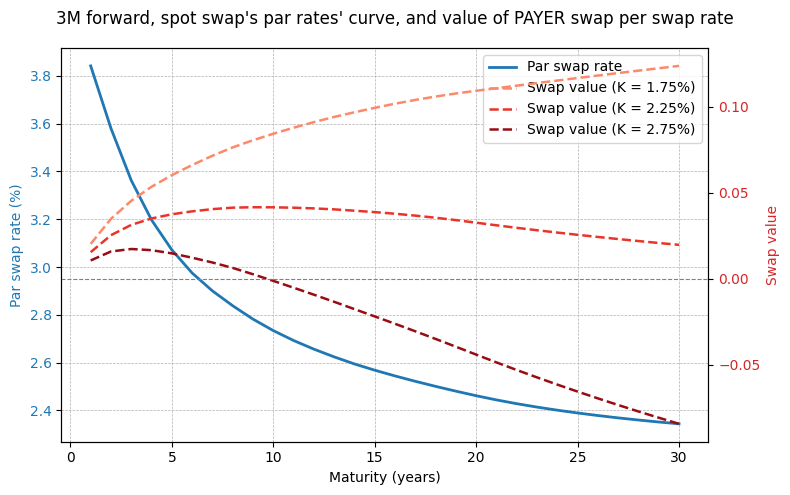

.......................
. Chapter 2.          .
. Forward swap rates. .
.......................


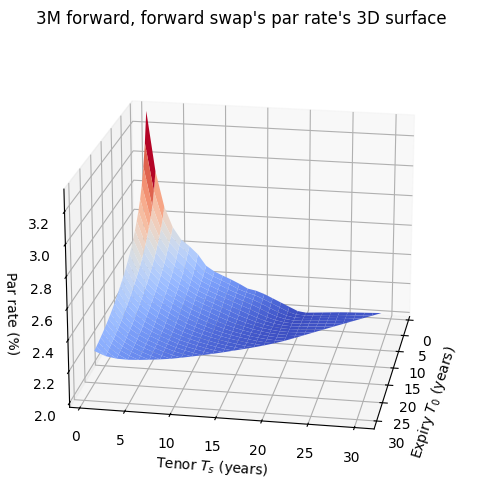

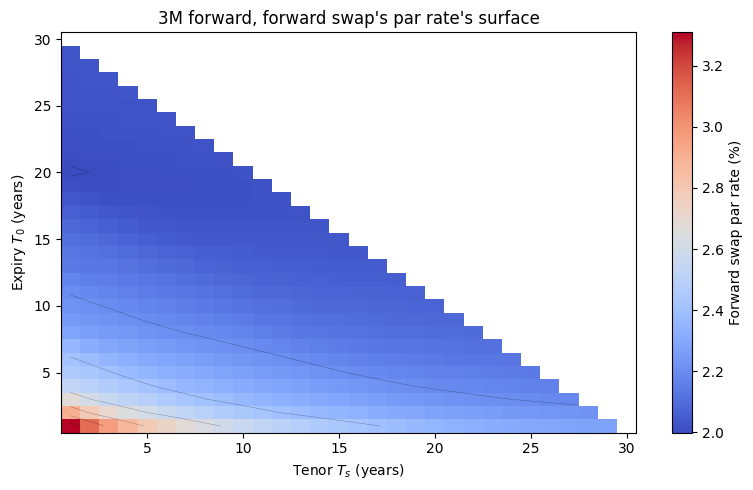

.........................
. Chapter 3.            .
. Implied volatilities. .
.........................


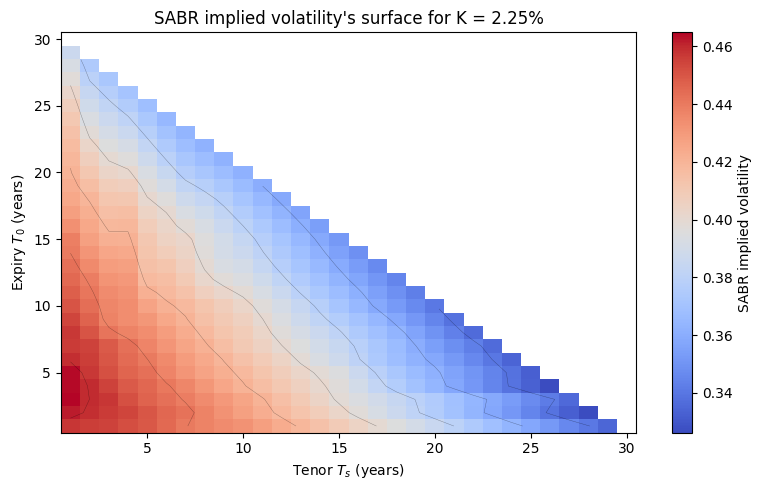

......................
. Chapter 4.         .
. Swaption's prices. .
......................


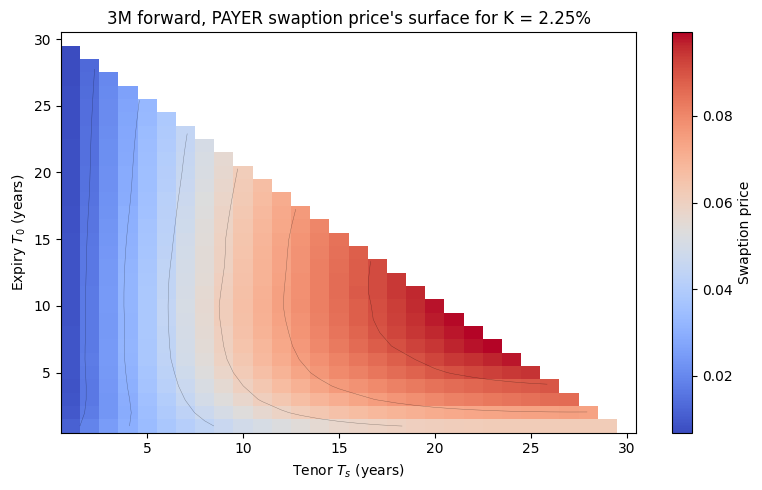

.................................
. Chapter 5.                    .
. Swap's and Swaption's prices. .
.................................


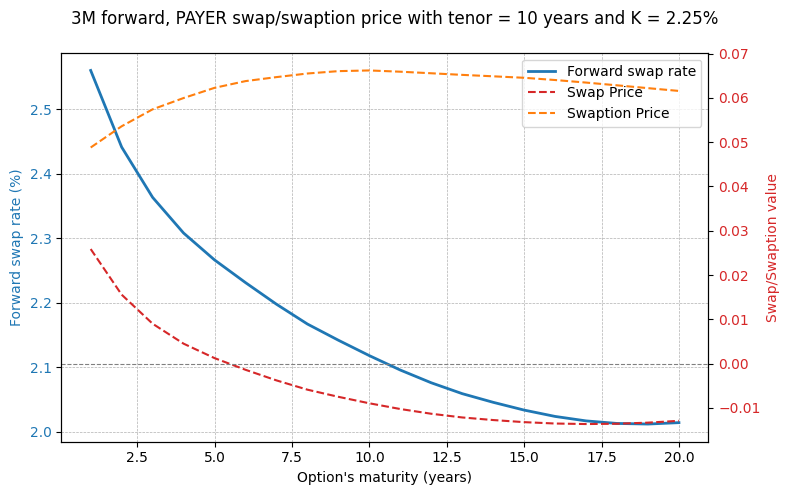

....................................................................................................
Option's maturity = 5 years
Swap's tenor = 10 years
Strike = 2.25%
Forward rate = 2.27%
Value of the 3M forward, PAYER swap = 0.0012526143773996913
Value of the 3M forward, PAYER swaption = 0.062251212772127855
Validation of the value of the swaption through comparison with the swap's value:
- PAYER swap = 0.001252614377399687 = PAYER swap - RECEIVER swap (-0.06099859839472817)
....................................................................................................


In [2653]:
if __name__ == "__main__":
    main()